# RT2 / Quant Insights

### Objectives of the Project

1. Fetch Historical Data of Stocks
2. Plot Graphs of Stock Prices
3. Apply Various Indicators and Strategies
4. Render Trade Signals
5. Backtest Applied Strategies
6. Create a Dashboard Utility and a Library for Reusable Technical Analysis (TA)

### Motivation

The motivation behind the project stems from our academic research on "Stochastic Processes and Its Applications" under Prof. S. Kaushik. We explored the realm of numbers and aimed to apply our mathematical discipline, along with probabilistic and statistical functions, to understand the stock market dynamics. Our goal was to investigate whether mathematics can predict stock price directions in this complex and human-driven field. Additionally, we undertook this project to implement our diverse skill sets in Finance, Data Analysis, and Machine Learning, while also enjoying the learning process.

## Acknowledgements
We would like to express our sincere gratitude to the following individuals and organizations:

* **Prof. S. Kaushik** for guiding us through our research on stochastic processes and its applications, which provided the foundation for this project.
* **Our peers and mentors** for their valuable feedback and support throughout the development of this project.
* **The open-source community** for providing valuable libraries and tools that facilitated the development of the RT2/Quant Insights project.
* Our institution, **Kirori Mal College, University of Delhi**, for providing the resources and support necessary to undertake this project.

### Contributors

* **Vansh Talvar** - KMC/2232119
* **Anjul Bhatia** - KMC/2232199 

### GitHub Repository

[RT2 GitHub Repository](https://www.github.com/anjulbhatia/rt2)

### References

(Include any references or sources you used in your research or project development here.)


## 1. Initiating the Project

In [1]:
# pip install yfinance pandas numpy matplotlib pywebview
# lightweight_charts: https://github.com/louisnw01/lightweight-charts-python
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from lightweight_charts.widgets import JupyterChart as Chart

%matplotlib inline  

## Data Fetcher Module

This module provides functionality to fetch financial data from various sources,
including stock, ETF, crypto, currency, and commodity data. It supports both static
methods for fetching data and instance methods for retrieving and processing data.

Right now this module has been restricted to fetching stock prices listed on various stock exchanges using Yahoo Finance.

In [2]:
def fetch_historical_data(ticker: str, start_date: str = None, end_date: str = None, period: str = None, interval: str = '1d') -> pd.DataFrame:
    if start_date is not None:
        end_date = end_date or datetime.today().strftime('%Y-%m-%d')
        data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    elif period is not None:
        data = yf.download(ticker, period=period, interval=interval)
    else:
        raise ValueError("Either 'period' or 'start_date' must be specified.")
    
    return data[["Open", "High", "Low", "Close", "Volume"]]

def fetch_realtime_data(ticker: str, period: str = '1d', interval: str = '1m') -> pd.DataFrame:
    data = yf.download(ticker, period=period, interval=interval)
    try:
        return data[["Open", "High", "Low", "Close", "Volume"]]
    except: return data

def fetch_company_info(ticker: str) -> dict:
    stock = yf.Ticker(ticker)
    return stock.info

In [3]:
# Example Use Case: fill in the parameters
ticker = "^NSEBANK"
start, end = "2023-08-01", "2024-07-31"

data = fetch_historical_data(ticker, start_date = start, end_date = end) # Takes start_date, end_date, period, interval as parameters
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2023-08-01,45740.000000,45782.750000,45471.050781,45592.500000,175200
2023-08-02,45234.648438,45404.898438,44720.898438,44995.699219,233600
2023-08-03,44862.851562,45038.449219,44279.398438,44513.449219,245800
2023-08-04,44754.750000,45118.050781,44520.550781,44879.500000,245200
2023-08-07,44993.699219,45011.351562,44773.851562,44837.500000,200800
...,...,...,...,...,...
2024-07-24,51657.648438,51944.648438,50784.250000,51317.000000,292200
2024-07-25,50762.300781,51006.101562,50559.898438,50888.750000,188400
2024-07-26,50456.101562,51398.601562,50438.300781,51295.949219,215700


<Axes: xlabel='Date'>

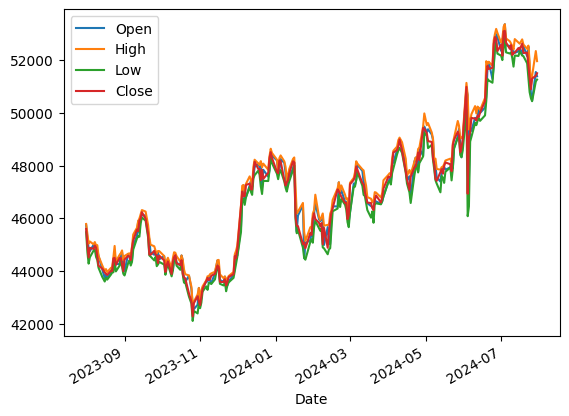

In [4]:
# DataFetcher objects inherit Pandas DataFrame features like plot and other methods and functions
data[["Open","High", "Low", "Close"]].plot()

In [5]:
# Get Company Details
fetch_company_info(ticker)

{'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 50685.55,
 'open': 50894.8,
 'dayLow': 50794.45,
 'dayHigh': 51080.0,
 'regularMarketPreviousClose': 50685.55,
 'regularMarketOpen': 50894.8,
 'regularMarketDayLow': 50794.45,
 'regularMarketDayHigh': 51080.0,
 'averageVolume': 203193,
 'averageVolume10days': 143650,
 'averageDailyVolume10Day': 143650,
 'fiftyTwoWeekLow': 42105.4,
 'fiftyTwoWeekHigh': 53357.7,
 'fiftyDayAverage': 51399.24,
 'twoHundredDayAverage': 47889.266,
 'currency': 'INR',
 'exchange': 'NSI',
 'quoteType': 'INDEX',
 'symbol': '^NSEBANK',
 'underlyingSymbol': '^NSEBANK',
 'shortName': 'NIFTY BANK',
 'longName': 'NIFTY BANK',
 'firstTradeDateEpochUtc': 1190000700,
 'timeZoneFullName': 'Asia/Kolkata',
 'timeZoneShortName': 'IST',
 'uuid': '266e9fd4-2e81-3570-9d92-e2ccf4a2b2ea',
 'messageBoardId': 'finmb_INDEXNSEBANK',
 'gmtOffSetMilliseconds': 19800000,
 'trailingPegRatio': None}

## Trade Strategies and Indicators

In [6]:
# Strategy and indicator functions
def mean_reversion_strategy(df, window=20, std_dev=2):
    df = df.copy()
    df['mean'] = df['Close'].rolling(window=window).mean()
    df['std'] = df['Close'].rolling(window=window).std()
    df['z_score'] = (df['Close'] - df['mean']) / df['std']
    
    df['upper_band'] = df['mean'] + (std_dev * df['std'])
    df['lower_band'] = df['mean'] - (std_dev * df['std'])

    df['signal'] = 0
    df.loc[df['z_score'] < -std_dev, 'signal'] = 1
    df.loc[df['z_score'] > std_dev, 'signal'] = -1
    return df

def gbm_simulation(S0, mu, sigma, T=1, dt=0.01):
    n_steps = int(T / dt)
    time = np.linspace(0, T, n_steps)
    W = np.random.standard_normal(size=n_steps)
    W = np.cumsum(W) * np.sqrt(dt)
    
    X = (mu - 0.5 * sigma**2) * time + sigma * W
    S = S0 * np.exp(X)
    
    return S

def rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def moving_average(prices, period=20, method='SMA'):
    if method == 'SMA':
        return prices.rolling(window=period).mean()
    elif method == 'EMA':
        return prices.ewm(span=period, adjust=False).mean()
    else:
        raise ValueError("Method must be 'SMA' or 'EMA'")

def kelly_criterion(win_probability, win_loss_ratio):
    kelly_fraction = win_probability - (1 - win_probability) / win_loss_ratio
    return kelly_fraction

def bollinger_bands(df, window=20, std_dev=2):
    df = df.copy()
    df['mean'] = df['Close'].rolling(window=window).mean()
    df['std'] = df['Close'].rolling(window=window).std()
    df['upper_band'] = df['mean'] + (std_dev * df['std'])
    df['lower_band'] = df['mean'] - (std_dev * df['std'])
    df['bandwidth'] = df['upper_band'] - df['lower_band']
    df['percent_bandwidth'] = (df['Close'] - df['lower_band']) / df['bandwidth']
    return df

In [7]:
# Apply the mean reversion strategy
result = mean_reversion_strategy(data)

# Display the result
result[['Close', 'mean', 'upper_band', 'lower_band', 'z_score', 'signal']].tail()

,Close,mean,upper_band,lower_band,z_score,signal
Date,,,,,,
2024-07-24,51317.000000,52423.417578,53251.073989,51595.761167,-2.673616,1
2024-07-25,50888.750000,52324.330078,53371.911465,51276.748691,-2.740751,1
2024-07-26,51295.949219,52248.562500,53364.795765,51132.329235,-1.706836,0
2024-07-29,51406.250000,52201.762500,53378.313886,51025.211114,-1.352278,0
2024-07-30,51499.300781,52147.990039,53350.776345,50945.203733,-1.078644,0


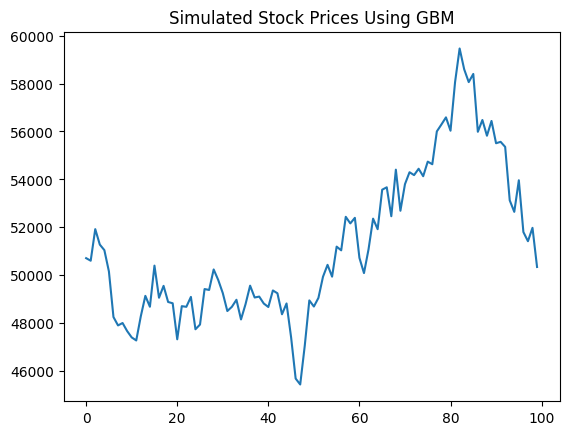

In [8]:
# Apply GBM Simulation
# Parameters
S0 = data['Close'].iloc[-1]  # Last closing price
mu = 0.1  # Example drift (10% annual return)
sigma = 0.2  # Example volatility (20% annual volatility)
T = 1  # Simulate for 1 year

# Simulate stock prices
simulated_prices = gbm_simulation(S0, mu, sigma, T)

# Plot the simulated prices
plt.plot(simulated_prices)
plt.title("Simulated Stock Prices Using GBM")
plt.show()

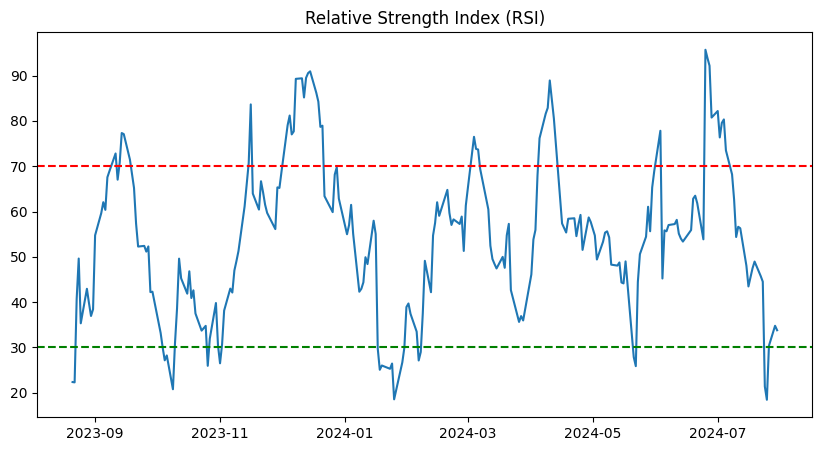

In [9]:
# Calculate RSI
data['RSI'] = rsi(data['Close'])

# Plot the RSI
plt.figure(figsize=(10, 5))
plt.plot(data['RSI'])
plt.title("Relative Strength Index (RSI)")
plt.axhline(70, color='r', linestyle='--')  # Overbought line
plt.axhline(30, color='g', linestyle='--')  # Oversold line
plt.show()

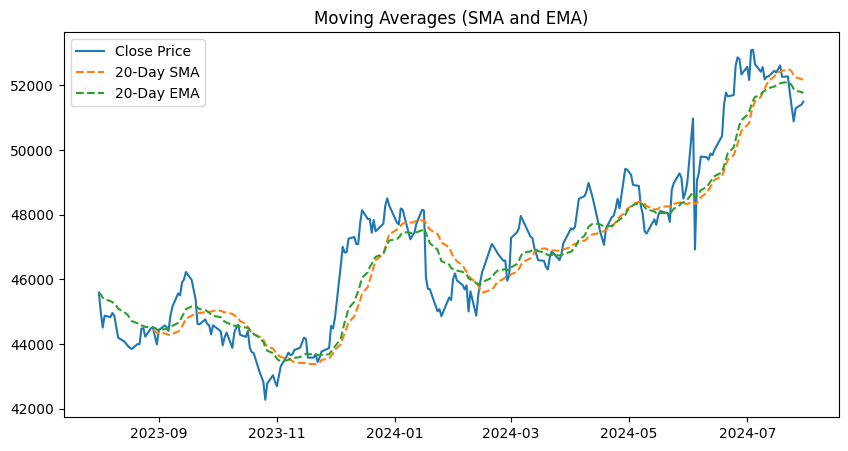

In [10]:
# Calculate SMA and EMA
data['SMA_20'] = moving_average(data['Close'], period=20, method='SMA')
data['EMA_20'] = moving_average(data['Close'], period=20, method='EMA')

# Plot the moving averages
plt.figure(figsize=(10, 5))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA_20'], label='20-Day SMA', linestyle='--')
plt.plot(data['EMA_20'], label='20-Day EMA', linestyle='--')
plt.legend()
plt.title("Moving Averages (SMA and EMA)")
plt.show()

In [11]:
# Example win probability and win/loss ratio
win_probability = 0.55  # 55% probability of winning
win_loss_ratio = 1.5  # Average win is 1.5 times the average loss

# Calculate Kelly Criterion
kelly_fraction = kelly_criterion(win_probability, win_loss_ratio)

# Display the result
print(f"The optimal fraction of capital to wager according to the Kelly Criterion is: {kelly_fraction:.2%}")


The optimal fraction of capital to wager according to the Kelly Criterion is: 25.00%


## TradeModel



In [12]:
class TradeModel:
    def __init__(self, data: pd.DataFrame = None, ticker: str = None):
        self.ticker = ticker
        self.data = data
    
    def set_ticker(self, ticker: str):
        self.ticker = ticker
        return ticker
    
    def get_data(self, period: str = "5y", start_date: str = None, end_date: str = None, interval: str = "1d") -> pd.DataFrame:
        if not self.ticker:
            raise ValueError("Ticker must be specified to fetch data.")
        
        self.data = fetch_historical_data(self.ticker, start_date=start_date, end_date=end_date, period=period, interval=interval)
        return self.data
    
    def load_data(self, data: pd.DataFrame):
        self.data = data
   
    def get_intraday(self, interval="1m"):
        if self.ticker:
            return fetch_realtime_data(ticker=self.ticker, interval=interval)
        else:
            raise ValueError("Ticker must be specified to fetch intraday data.")

    def get_company_info(self):
        if self.ticker:
            return fetch_company_info(ticker=self.ticker)
        else:
            raise ValueError("Ticker must be specified to fetch company information.")

    def apply_strategy(self, strategy_name: str, **kwargs):
        if self.data is None:
            raise ValueError("Data must be loaded or fetched before applying a strategy.")
        
        if strategy_name == 'mean_reversion':
            return mean_reversion_strategy(self.data, **kwargs)
        else:
            raise ValueError(f"Strategy {strategy_name} not recognized.")

    def apply_indicator(self, indicator_name: str, **kwargs):
        if self.data is None:
            raise ValueError("Data must be loaded or fetched before applying an indicator.")
        
        if indicator_name == 'rsi':
            self.data['RSI'] = rsi(self.data['Close'], **kwargs)
        elif indicator_name == 'moving_average':
            self.data['Moving_Average'] = moving_average(self.data['Close'], **kwargs)
        elif indicator_name == 'kelly_criterion':
            # Kelly Criterion would typically not be applied to price data directly.
            return kelly_criterion(**kwargs)
        elif indicator_name == 'bollinger_bands':
            self.data = bollinger_bands(self.data, **kwargs)
        else:
            raise ValueError(f"Indicator {indicator_name} not recognized.")
        return self.data

    def execute_trade(self, signal, qty):
        if signal == 1:
            print(f"Buy order for {self.ticker} with quantity {qty}")
        elif signal == -1:
            print(f"Sell order for {self.ticker} with quantity {qty}")

    def fetch_real_time_data(self):
        return fetch_realtime_data(self.ticker)

    def update_data_frame(self, new_data):
        self.data = pd.concat([self.data, new_data]).drop_duplicates().reset_index(drop=True)
        return self.data

    def real_time_trading(self, capital, kelly_fraction, interval=60):
        self.trade_log = list()
        while True:
            try:
                new_data = self.fetch_real_time_data()
                if not new_data.empty:
                    self.data = self.update_data_frame(new_data)
                    self.data = self.apply_strategy('mean_reversion', window=20, std_dev=2)
                    signal = self.data['signal'].iloc[-1]

                    # Simulate future prices using GBM
                    S0 = self.data['Close'].iloc[-1]
                    mu = 0.001  # example expected return
                    sigma = 0.02  # example volatility
                    simulated_prices = gbm_simulation(S0, mu, sigma)
                    expected_price = simulated_prices[-1]

                    # Add GBM-based signal logic
                    if expected_price > self.data['upper_band'].iloc[-1]:
                        signal = -1
                    elif expected_price < self.data['lower_band'].iloc[-1]:
                        signal = 1

                    # Determine position size based on Kelly criterion
                    position_size = int(capital * kelly_fraction)

                    # Log trade
                    self.trade_log.append({
                        'time': pd.Timestamp.now(),
                        'symbol': self.ticker,
                        'signal': 'Buy' if signal == 1 else 'Sell',
                        'quantity': position_size,
                        'price': S0
                    })

                    self.execute_trade(signal, qty=position_size)
                
                # Plot updated signals (optional, implement if needed)
                # plot_signals(self.data)
                
                # Wait for next iteration
                time.sleep(interval)
            
            except KeyboardInterrupt:
                print("Trading stopped.")
                break
            except Exception as e:
                print(f"Error: {e}")
                continue

        # Convert trade log to DataFrame and save to CSV
        trade_log_df = pd.DataFrame(self.trade_log)
        trade_log_df.to_csv('trade_log.csv', index=False)
        print(trade_log_df)


In [13]:
tm = TradeModel()
tm.set_ticker("TATAMOTORS.NS")
tm.get_data(period="1y") # Since period or time bound is not diven default period of 5 Yr is produced

# Apply Mean Reversion Strategy
strategy_df = tm.apply_strategy('mean_reversion', window=20, std_dev=2)
print(strategy_df)

# Apply RSI Indicator
indicator_df = tm.apply_indicator('rsi', period=14)
print(indicator_df)

# Apply Moving Average Indicator
ma_df = tm.apply_indicator('moving_average', period=50, method='EMA')
print(ma_df)

# Apply Bollinger Bands Indicator
bollinger_df = tm.apply_indicator('bollinger_bands', window=20, std_dev=2)
print(bollinger_df)


[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Volume  \
Date                                                                       
2023-08-22   621.799988   626.500000   618.599976   620.200012   8534395   
2023-08-23   622.750000   622.750000   613.150024   613.900024   8248333   
2023-08-24   618.000000   619.000000   609.650024   610.950012   7096025   
2023-08-25   610.849976   616.700012   593.299988   605.099976  16075509   
2023-08-28   605.400024   608.500000   601.549988   602.400024   7479254   
...                 ...          ...          ...          ...       ...   
2024-08-16  1072.000000  1099.949951  1070.000000  1098.349976  11435650   
2024-08-19  1105.900024  1107.000000  1085.000000  1087.699951   6911441   
2024-08-20  1097.000000  1098.050049  1082.050049  1086.900024   5625723   
2024-08-21  1089.000000  1095.300049  1083.300049  1085.199951   4869876   
2024-08-22  1090.000000  1094.750000  1064.949951  1068.449951   9376692   

           

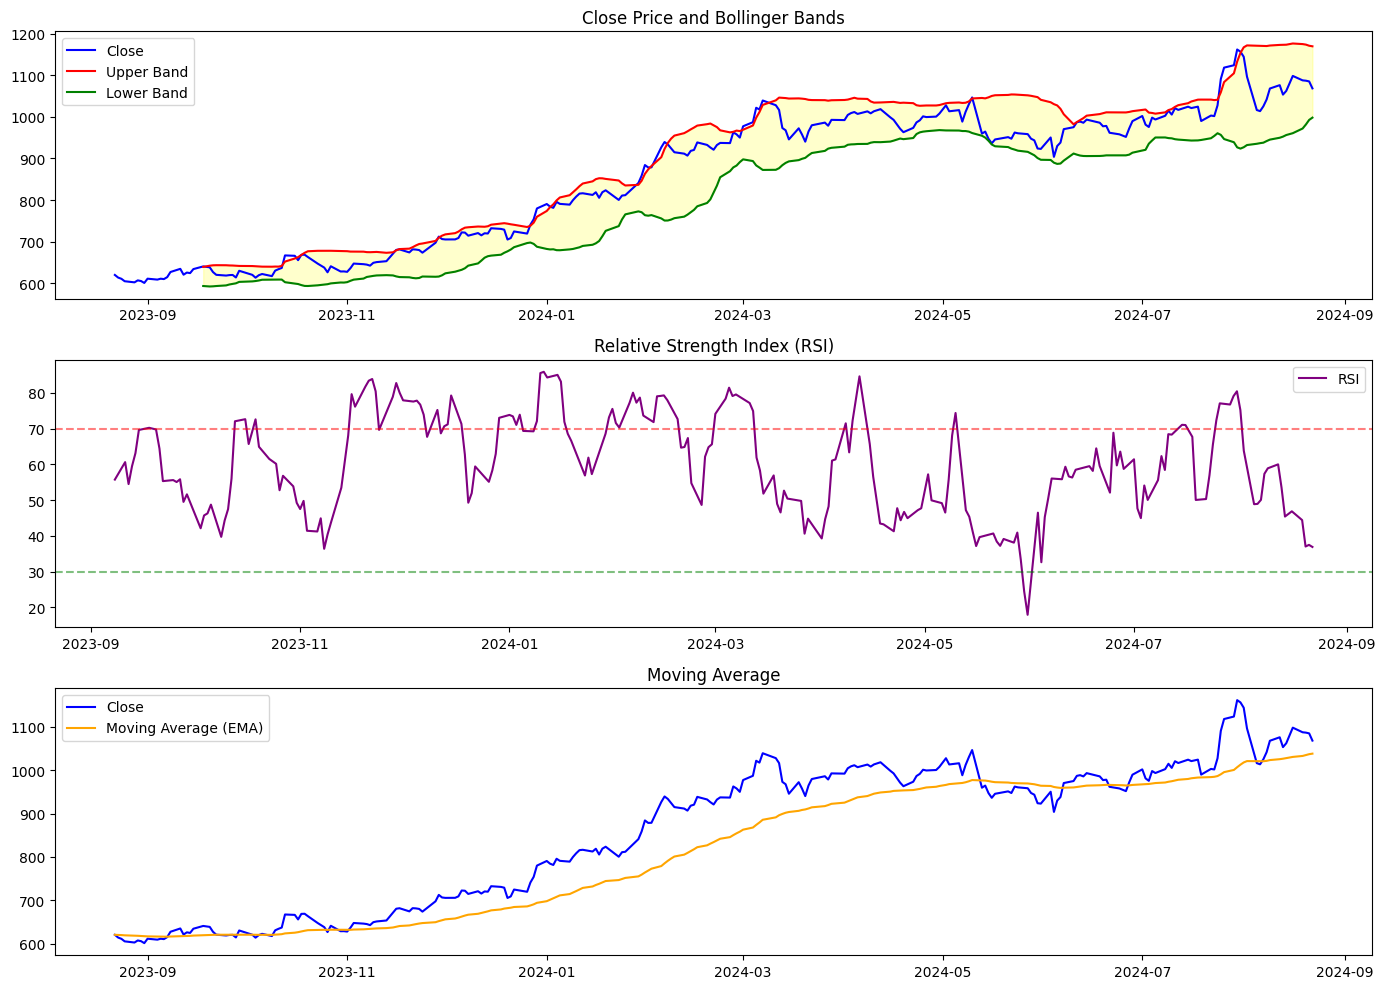

In [14]:
# Plotting with matplotlib
plt.figure(figsize=(14, 10))

# Plot Closing Price and Bollinger Bands
plt.subplot(3, 1, 1)
plt.plot(strategy_df.index, strategy_df['Close'], label='Close', color='blue')
plt.plot(strategy_df.index, strategy_df['upper_band'], label='Upper Band', color='red')
plt.plot(strategy_df.index, strategy_df['lower_band'], label='Lower Band', color='green')
plt.fill_between(strategy_df.index, strategy_df['upper_band'], strategy_df['lower_band'], color='yellow', alpha=0.2)
plt.title('Close Price and Bollinger Bands')
plt.legend()

# Plot RSI
plt.subplot(3, 1, 2)
plt.plot(indicator_df.index, indicator_df['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', color='red', alpha=0.5)
plt.axhline(30, linestyle='--', color='green', alpha=0.5)
plt.title('Relative Strength Index (RSI)')
plt.legend()

# Plot Moving Average
plt.subplot(3, 1, 3)
plt.plot(ma_df.index, ma_df['Close'], label='Close', color='blue')
plt.plot(ma_df.index, ma_df['Moving_Average'], label='Moving Average (EMA)', color='orange')
plt.title('Moving Average')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# Real-time trading example
capital = 10000  # Example capital
kelly_fraction = 0.1  # Example Kelly Criterion fraction
tm.real_time_trading(capital, kelly_fraction, interval=60)

[*********************100%%**********************]  1 of 1 completed


Sell order for TATAMOTORS.NS with quantity 1000


[*********************100%%**********************]  1 of 1 completed


Sell order for TATAMOTORS.NS with quantity 1000


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Sell order for TATAMOTORS.NS with quantity 1000


[*********************100%%**********************]  1 of 1 completed


Sell order for TATAMOTORS.NS with quantity 1000


[*********************100%%**********************]  1 of 1 completed


Buy order for TATAMOTORS.NS with quantity 1000


[*********************100%%**********************]  1 of 1 completed


Buy order for TATAMOTORS.NS with quantity 1000


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Buy order for TATAMOTORS.NS with quantity 1000


[*********************100%%**********************]  1 of 1 completed


Buy order for TATAMOTORS.NS with quantity 1000


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Buy order for TATAMOTORS.NS with quantity 1000


[*********************100%%**********************]  1 of 1 completed


Trading stopped.
                         time         symbol signal  quantity        price
0  2024-08-22 23:52:15.240323  TATAMOTORS.NS   Sell      1000  1068.449951
1  2024-08-22 23:53:15.633469  TATAMOTORS.NS   Sell      1000  1068.449951
2  2024-08-22 23:54:16.038142  TATAMOTORS.NS   Sell      1000  1068.449951
3  2024-08-22 23:55:16.387204  TATAMOTORS.NS   Sell      1000  1068.449951
4  2024-08-22 23:56:16.783195  TATAMOTORS.NS   Sell      1000  1068.449951
5  2024-08-22 23:57:17.201733  TATAMOTORS.NS   Sell      1000  1068.449951
6  2024-08-22 23:58:17.595335  TATAMOTORS.NS    Buy      1000  1068.449951
7  2024-08-22 23:59:17.987444  TATAMOTORS.NS    Buy      1000  1068.449951
8  2024-08-23 00:00:18.362784  TATAMOTORS.NS   Sell      1000  1068.449951
9  2024-08-23 00:01:18.748052  TATAMOTORS.NS    Buy      1000  1068.449951
10 2024-08-23 00:02:19.158931  TATAMOTORS.NS    Buy      1000  1068.449951
11 2024-08-23 00:03:19.539792  TATAMOTORS.NS   Sell      1000  1068.449951
12 2024-